In [1]:
# !pip install torch==2.2
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install numpy
!pip install matplotlib
!pip install torchsummary
# !pip install torchview
# !pip install graphviz
# !pip install torchviz
!pip install pandas
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=33e4463a0652e29c40e6871045cfd813643ad8f08e8e6056390cf863e42cc06c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import seaborn as sns
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
BATCH_SIZE = 64
num_epoch = 10
learning_rate = 1e-4
class_size = 10

In [7]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.ToTensor()])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()])

In [8]:
!ls /content/drive/MyDrive/hurricane_damage/

QNN_TRAIN_CPU_hurricane_W4_X_S0_E10000_s1.npy	  QNN_TRAIN_CPU_hurricane_W4_XY_S0_E5000_s1.npy
QNN_TRAIN_CPU_hurricane_W4_X_S0_E10000_s2.npy	  QNN_TRAIN_CPU_hurricane_W4_XY_S5000_E10000_s1.npy
QNN_TRAIN_CPU_hurricane_W4_X_S0_E5000_s1.npy	  raw_hurricane_dataset
QNN_TRAIN_CPU_hurricane_W4_X_S5000_E10000_s1.npy  train_another_labels.npy
QNN_TRAIN_CPU_hurricane_W4_XY_S0_E10000_s1.npy


In [9]:
torch.manual_seed(2024)
!ls
# train = torchvision.datasets.CIFAR100("./data-cifar100/", train=True, download=True, transform=transform_train)
train = torchvision.datasets.ImageFolder("/content/drive/MyDrive/hurricane_damage/raw_hurricane_dataset/train_another/", transform=transform_test)

val_size = 2000
train_size = len(train) - val_size

train, val = random_split(train, [train_size, val_size])

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

drive  sample_data


shape:  torch.Size([64, 3, 224, 224])


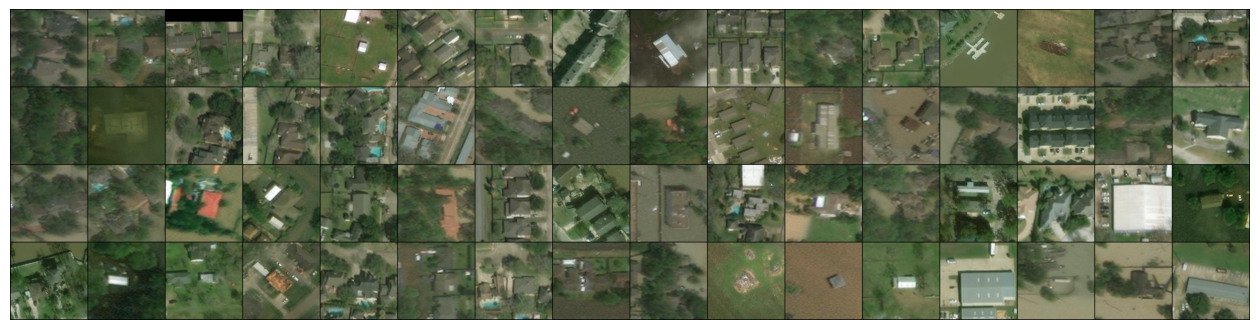

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    print('shape: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [11]:
from torchvision import models

model = models.resnet18(pretrained=True)
# model = torch.load('/content/drive/MyDrive/res/effnet_cifar_reference-2.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
input_last_year = model.fc.in_features
model.fc = nn.Linear(input_last_year, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [16]:
epoch_loss_history = []
epoch_acc_history = []

In [24]:

# torch.cuda.empty_cache()

train_additional_transformations = transforms.RandomHorizontalFlip(p=0.7)

for epoch in range(num_epoch):
    epoch_avg_loss = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = train_additional_transformations(imgs.to(device))
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_avg_loss += loss_value.item()

        accuracy = (n_corrects / labels.size(0)) * 100

        if (i+1) % 10 == 0:
            print(f'epoch {epoch + 1}/{num_epoch}, step: {i + 1}/{train_size/BATCH_SIZE}: loss = {loss_value:.5f}, acc = {accuracy:.2f}')

    epoch_loss_history.append(epoch_avg_loss / len(train_loader))

    with torch.no_grad():
        correct = 0
        samples = 0

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = outputs.max(1)
            correct += (predictions == labels).sum()
            samples += predictions.size(0)

        accuracy = float(correct) / float(samples) * 100
        epoch_acc_history.append(accuracy)

        print(f"epoch {epoch + 1}/{num_epoch}, val accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")

epoch 1/10, step: 10/125.0: loss = 0.06313, acc = 100.00
epoch 1/10, step: 20/125.0: loss = 0.10244, acc = 95.31
epoch 1/10, step: 30/125.0: loss = 0.08733, acc = 98.44
epoch 1/10, step: 40/125.0: loss = 0.14710, acc = 90.62
epoch 1/10, step: 50/125.0: loss = 0.22102, acc = 89.06
epoch 1/10, step: 60/125.0: loss = 0.05073, acc = 98.44
epoch 1/10, step: 70/125.0: loss = 0.08440, acc = 96.88
epoch 1/10, step: 80/125.0: loss = 0.07162, acc = 98.44
epoch 1/10, step: 90/125.0: loss = 0.12271, acc = 95.31
epoch 1/10, step: 100/125.0: loss = 0.04939, acc = 100.00
epoch 1/10, step: 110/125.0: loss = 0.03224, acc = 100.00
epoch 1/10, step: 120/125.0: loss = 0.13190, acc = 95.31
epoch 1/10, val accuracy = 95.20%. Correct 1904 out of 2000 samples
epoch 2/10, step: 10/125.0: loss = 0.05848, acc = 100.00
epoch 2/10, step: 20/125.0: loss = 0.09526, acc = 95.31
epoch 2/10, step: 30/125.0: loss = 0.06262, acc = 98.44
epoch 2/10, step: 40/125.0: loss = 0.18271, acc = 89.06
epoch 2/10, step: 50/125.0: l

In [25]:
print(epoch_loss_history)


[0.5129353699684143, 0.26328768372535705, 0.19679927188158036, 0.16497703242301942, 0.1458117577433586, 0.1311893161535263, 0.11983712977170945, 0.10932251620292664, 0.10218596550822258, 0.09324597716331481, 0.09063698956370354, 0.08263288208842277, 0.0775690932571888, 0.07373370458185673, 0.06789323413372039, 0.06689219991862774, 0.06172084507346153, 0.056408766835927965, 0.05324291426688433, 0.0538421226888895]


In [26]:
print(epoch_acc_history)


[88.2, 91.60000000000001, 92.60000000000001, 93.2, 93.8, 94.1, 94.45, 94.69999999999999, 94.89999999999999, 95.1, 95.19999999999999, 95.3, 95.3, 95.39999999999999, 95.6, 95.7, 95.8, 95.95, 96.1, 96.15]


In [27]:
with open('/content/drive/MyDrive/res/history/resnet_hurricane_refrence_loss_history.txt', "w") as f:
    for item in epoch_loss_history:
        f.write(f'{item:.5f}\n')

In [28]:
with open('/content/drive/MyDrive/res/history/resnet_hurricane_refrence_acc_history.txt', "w") as f:
    for item in epoch_acc_history:
        f.write(f'{item:.5f}\n')

In [29]:
torch.save(model, '/content/drive/MyDrive/res/resnet_hurricane_reference.pth')